In [38]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy import signal
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import matplotlib.pyplot as plt
import os
from neo import io
import pandas as pd
from tqdm import tqdm
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FormatStrFormatter
import matplotlib.image as mpimg

from lfpmodel import deriv_receptor, get_stim_func
from lfpan import get_means
from multicomp import deriv_known_LFP, deriv_known_Vis
from utils import filter_expon, rescale, filter_from_coefs

plt.style.use('pcb')

In [31]:
params = np.array([ 1., 2.2, 12, 14, 28])
conc, *deriv_params = params

max_step = 1e-3
t_min = -0.1
t_max = 3
tarr = np.linspace(t_min, t_max, 50000)

args = (get_stim_func(2, conc), *deriv_params)
y0 = np.array([1, 0, 0])
res_lfp = solve_ivp(deriv_receptor, t_span=(t_min,t_max), y0=y0, args=args, t_eval=tarr, max_step=max_step)
rescaling = 7.3
LFP = UnivariateSpline(tarr*1000, 35-res_lfp.y[2]*rescaling, k=1, s=0, ext=3)

In [32]:
shapes = [1, 1, 1]
taus = [1e-3, 40e-3, 0.8]

dt = tarr[1] - tarr[0]

tarr_filt, filt = filter_from_coefs([-96, 81, 15.5], taus, shapes, dt)

firing = np.convolve(-res_lfp.y[2]*rescaling, filt[::1], mode='full')[:-len(filt)+1]

In [33]:
q = 30

soma_adapt = UnivariateSpline(tarr*1000, firing/q-62, k=1, s=0, ext=3)
soma_intact = UnivariateSpline(tarr*1000, Vis, k=1, s=0, ext=3)
input_current = UnivariateSpline(tarr*1000, Ir, k=1, s=0, ext=3)

In [34]:
ret_Ir = True

if ret_Ir:
    y0 = (35, -62, 35, -62, 0, 0, 0, 0, 0, 0)
else:
    y0 = (35,-62, 35,-62)


res = solve_ivp(lambda t, y: deriv_known_LFP(t, y, LFP, ret_Ir=ret_Ir),
          t_span=(t_min*1000,t_max*1000), y0=y0, t_eval=tarr*1000,
               max_step=1e-1)

if ret_Ir:
    Vea, Vis, Ved, Vid, Ir, Ie, Ild, Ia, Ii, Ils = res.y
else:
    Vea, Vis, Ved, Vid = res.y
    
Ir, Ie, Ild, Ia, Ii, Ils = np.array([deriv_known_LFP(t, x, LFP, ret_Ir=True)[4:] for x, t in zip(res.y.T, tarr*1000)]).T

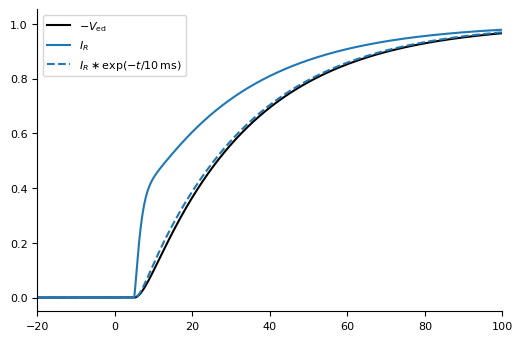

In [35]:
def plot_Ir(ax, xmin=-20, xmax=100, smooth=True):
    dt = tarr[1] - tarr[0]

    ax.plot(tarr*1000, rescale(-(Ved-35)), color='black', label=r'$-V_{\mathrm{ed}}$')
    
    ax.plot(tarr*1000, rescale(Ir), color='C0', label=r'$I_R$')
    
    if smooth == True:
        ax.plot(tarr*1000, filter_expon(rescale(Ir), tau=0.01, shape=1, dt=dt),
               color='C0', linestyle='dashed', label=r'$I_R\ast\exp(-t/10\,\mathrm{ms})$')
    # plt.plot(tarr*1000, Ild)
    # plt.plot(tarr, Vea)
    ax.set_xlim(xmin, xmax)
    
fig, ax = plt.subplots()
plot_Ir(ax)
ax.legend()

In [36]:
def potentials_adapting(adapt_type):
    ret_Ir = False

    if ret_Ir:
        y0 = (35, -62, 35, -62, 0, 0, 0, 0, 0, 0)
    else:
        y0 = (35,-62, 35,-62)

        
    if adapt_type == 'thr':
        soma = soma_intact
    elif adapt_type == 'ahp':
        soma = soma_adapt

    res = solve_ivp(lambda t, y: deriv_known_Vis(t, y, input_current, soma, ret_Ir=ret_Ir),
              t_span=(t_min*1000,t_max*1000), y0=y0, t_eval=tarr*1000,
                   max_step=1e-1)

    if ret_Ir:
        Vea, Vis, Ved, Vid, Iad, Ie, Ild, Ia, Ii, Ils = res.y
    else:
        Vea, Vis, Ved, Vid = res.y
    
    Iad, Ie, Ild, Ia, Ii, Ils = np.array([deriv_known_Vis(t, x, input_current, soma, ret_Ir=True)[4:] for x, t in zip(res.y.T, tarr*1000)]).T
    
    return Vea, Vis, Ved, Vid

In [39]:
Vea_thr, Vis_thr, Ved_thr, Vid_thr = potentials_adapting('thr')
Vea_ahp, Vis_ahp, Ved_ahp, Vid_ahp = potentials_adapting('ahp')

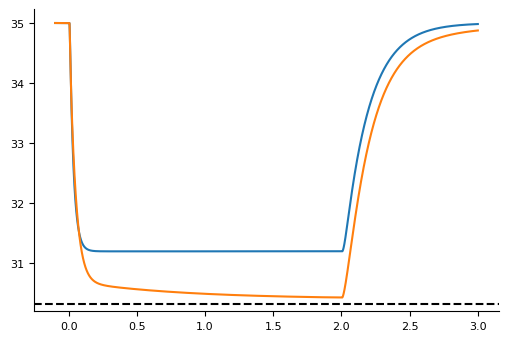

In [40]:
plt.plot(tarr, Ved_thr)
plt.plot(tarr, Ved_ahp)
plt.axhline(Ved_ahp.min()-0.1, linestyle='dashed', color='black')